# How many people think that Threads is just a bad copy of Twitter?

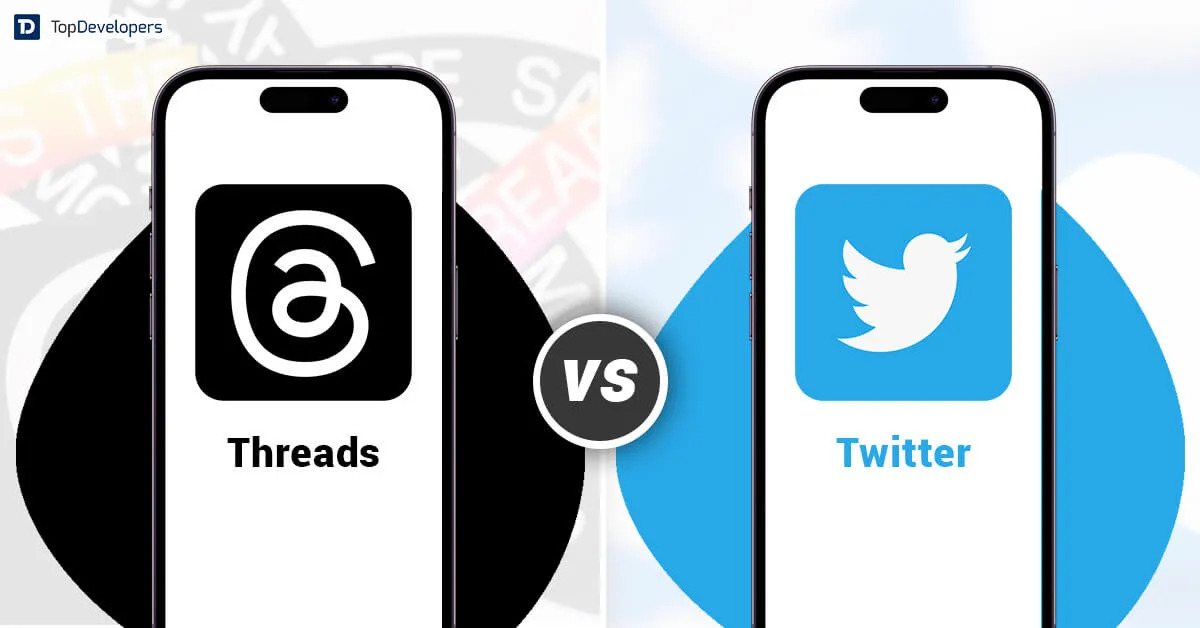

I think Threads is just a fruit of the pointless 'battle' between Elon and Mark. I won't be using Threads, just as I don't use Twitter. In the other hand, I want to know that the people loved Threads or not. For that purpose I'll use my only skill(which is coding). We are going to do sentiment analysis, build, train and evalute a model, and in the and we'll create a bunch of synthetic reviews(mostly very agressive), see if our model can correctly classify or not. So, let's get started!

# Libraries 📖

You can find all the libraries that we're going to use, through this cell below.

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.base import clone
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Greeting the Data 📍 

It is always a good idea take a quick peek to the dataset before to start preprocessing and cleaning. 

In [2]:
reviews = pd.read_csv('/kaggle/input/threads-an-instagram-app-reviews/threads_reviews.csv')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              32910 non-null  object
 1   review_description  32910 non-null  object
 2   rating              32910 non-null  int64 
 3   review_date         32910 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


We have 4 different columns. So, what are these columns? Are all of them very important? How can we determine that which one is important and others not?

In [3]:
reviews.head(6)

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43
5,Google Play,"Currently, it's very challenging to use. It's ...",2,2023-07-18 22:30:10


* **source** - *This column determines the platform, that the review coming from.*
* **review_description** - *The review itself.*
* **rating** - *The number of stars that given to the app(in that case, it's Threads).*
* **review_date** - *The exact time that the person wrote the review.*

# Data Cleaning, Visulization and Text Preprocessing 📍

We're going to use supervised algorithms for building our model and supervised algorithms needs label(or sometimes labels). So, let's create our label.

In [4]:
#A function for converting polarity values into categorical features.
def get_sentiment(text):
    if TextBlob(text).sentiment.polarity < 0:
        return 'Negative'
    elif TextBlob(text).sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Positive'

reviews['sentiment'] = reviews['review_description'].apply(lambda x: get_sentiment(x))

reviews['sentiment'].head(5)

0    Positive
1    Positive
2    Positive
3    Positive
4    Positive
Name: sentiment, dtype: object

Sentiment Polarity gives us a value between [-1: 1]. 0 means that the review is neutral, negative value means that the review is mostly negative and so on. The cell above helps us to determine polarity for each instance in our dataframe.  

We created our label and it's time to visualize the data to gain some insights.

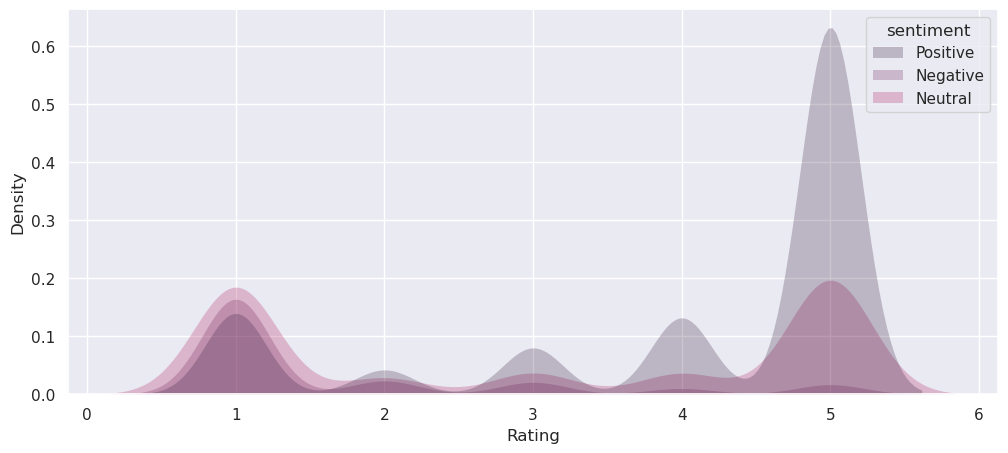

In [5]:
sns.set_theme(style = 'darkgrid', palette = 'rocket')
plt.figure(figsize = (12,5))
sns.kdeplot(data = reviews, x = 'rating', hue = 'sentiment', fill = True, linewidth = 0)
plt.xlabel('Rating')
plt.show()

As you may expect, most of the positive reviews have 5 stars for the app, and for the negatives, this value is 1.

**Note:** *Even with a quick looking to the graph, you can understand most of the people loved this app(to be honest, this situation is very awkard for me).*

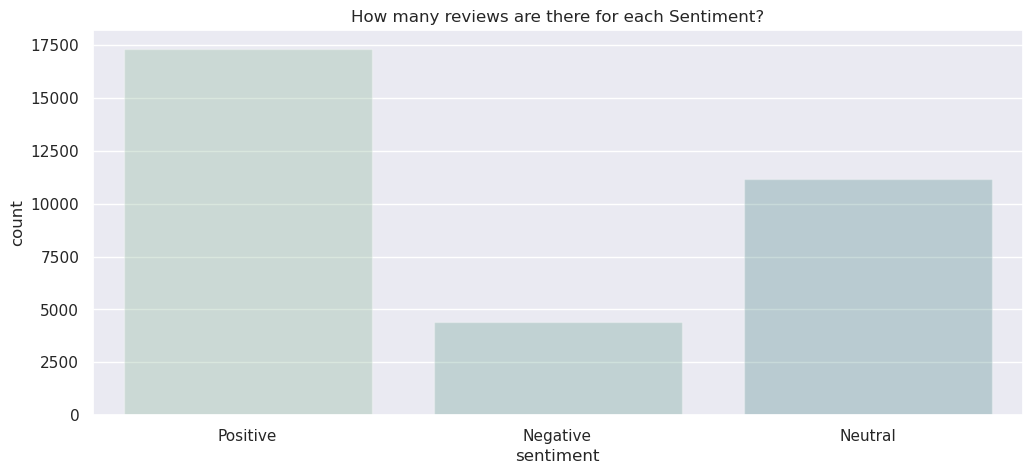

In [6]:
sns.set_theme(style = 'darkgrid', palette = 'crest')
plt.figure(figsize = (12,5))
plt.title('How many reviews are there for each Sentiment?')
sns.countplot(data = reviews, x = 'sentiment', alpha = 0.3)
plt.show()

In machine terms, the data is very imbalanced. There're very few 'Negative' reviews (which is interesting) and too many 'Positive' review for the app. If we ignore 'the unbalancing data' problem, our model will struggle when learning and predicting 'Negative' reviews.

You can use various techniques to handle with imbalanced data:
* **Undersampling.**
* **SMOTE.**
* **Ensemble Method.**

We're going to use the SMOTE for this particular situation. Basically, SMOTE(Synthetic Minority Over-sampling Technique) creates synthetic samples for the class which has relatively few samples.

(-0.5, 999.5, 599.5, -0.5)

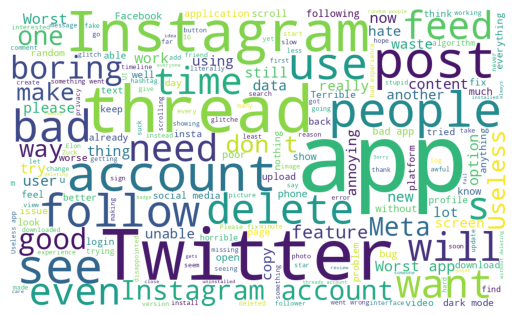

In [7]:
all_text = ' '.join(reviews['review_description'].loc[reviews['sentiment'] == 'Negative'])
word_cloud = WordCloud(width=1000, height=600, background_color='white').generate(all_text)
sns.set_theme(style = 'white', palette = 'pastel')
plt.imshow(word_cloud)
plt.axis('off')

Word Clouds is a very good way to visualize the 'bag of words'. Word 'bigness' represents frequency of the word. Bigger means more frequent.

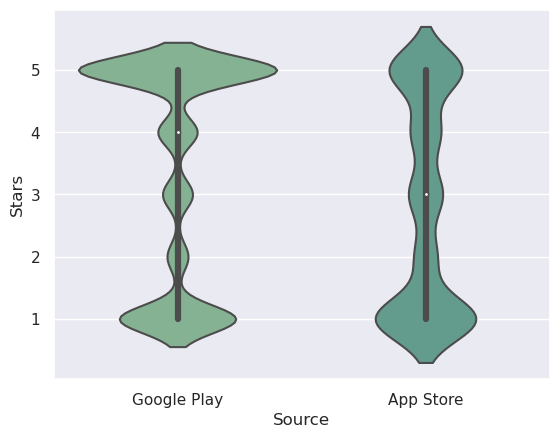

In [8]:
sns.set_theme(style = 'darkgrid', palette = 'crest')
sns.violinplot(data = reviews, x = 'source', y = 'rating', alpha = 0.3)
plt.xlabel('Source')
plt.ylabel('Stars')
plt.show()

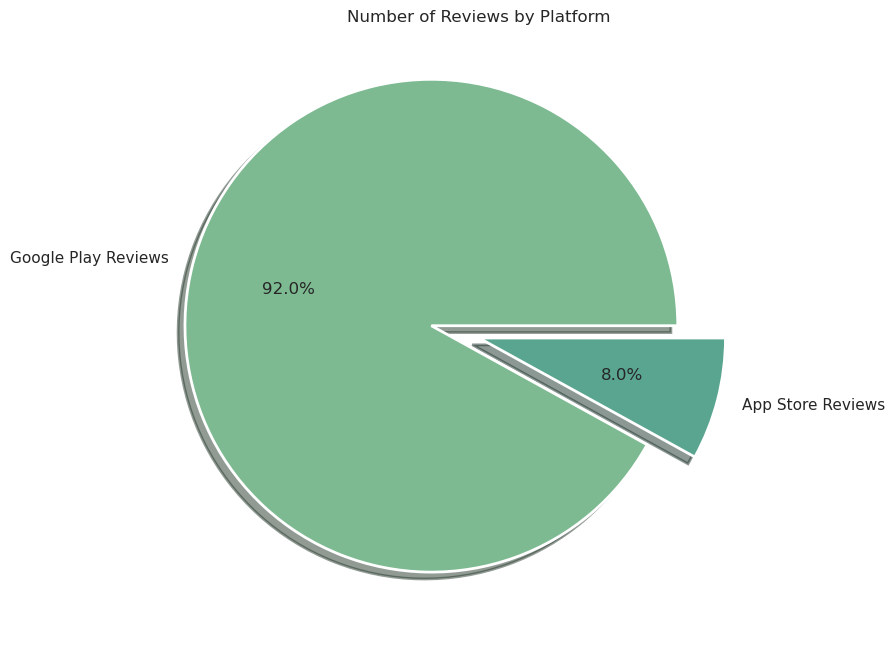

In [9]:
sns.set_theme(palette = 'crest')
plt.figure(figsize=(8,8))
plt.pie(x = [len(reviews[reviews['source'] == 'Google Play']), len(reviews[reviews['source'] == 'App Store'])],
         shadow = True, wedgeprops = {'linewidth': 2, 'edgecolor': 'white'}, explode = [0.2, 0.0], 
         labels = ['Google Play Reviews', 'App Store Reviews'], autopct = '%1.1f%%')
plt.title('Number of Reviews by Platform')
plt.show()

As you can see this column is very imbalanced. Very few of the reviews is coming from App Store, so we may consider to drop this column.

**Note:** *In real life all of these features may help to demonstrate wheter the person happy or not about this app. For example, maybe in 6th of Jule the app may working poorly and people could be angry, but in 8th of July they may launch a new patch and fix the errors. From this date the negative reviews may turning to positive. But don't ever forget! This is a machine not a people, its way of thinking is very different from us. When we building a model we should think like a machine, and try to emphaty with it.*

In [10]:
#Let's create a copy of the dataset, so we can freely play with the dataset.
reviews_copy = reviews.copy()
reviews_copy = reviews_copy.drop(['review_date', 'source'], axis = 1)

For text preprocessing we're going to use spaCY library. This library makes text preprocessing very convenient and more interesting. If you learn more about spaCY and text preprocessing, check the links below 👇:
* *https://spacy.io*
* *https://towardsdatascience.com/text-preprocessing-in-natural-language-processing-using-python-6113ff5decd8*

In [11]:
nlp = spacy.load("en_core_web_sm")

In [12]:
text = 'A'
#preprocessing phase
def preprocessing_text(df = reviews_copy):
    
    #Lowering the text
    df['lowered'] = df['review_description'].apply(lambda x: x.lower())
    
    #Tokenization
    df['tokens'] = df['lowered'].apply(lambda x: nlp(x))
    
    #Removing punctuation.
    df['no_punct'] = df['tokens'].apply(lambda x: [word for word in x if word.is_punct == False])
    
    #Removing stopwords.
    #df['no_stops'] = df['no_punct'].apply(lambda x: [word for word in x if word.is_stop == False])
    
    """
    In some cases you may want to remove stop words, but in this case stop words may help the model to
    predict better. (For example, 'not' is a stop words and also contains negativity. If we remove 'not'
    the sentiment polarity may increase and we loss some 'negativity'. In case, if you want to remove
    stop words, just remove '#' symbol above.
    
    """
    #Lemmatization.
    df['lemmatized'] = df['no_punct'].apply(lambda x: [word.lemma_ for word in x])
    
    #Joining together.
    df['review_filtered'] = df['lemmatized'].apply(lambda x: ' '.join(x))
    
    return df['review_filtered']      

This function returns takes a dataframe as an input and return a 'filtered' column as an output. 

In [13]:
reviews['preprocessed'] = preprocessing_text(df = reviews_copy)
reviews['preprocessed'].head(10)

0    meh not the great experience on a chromebook s...
1    pretty good for a first launch its easy to use...
2    for a brand new app it be very well optimize h...
3    great app with a lot of potential however ther...
4    the app be good but it need a lot of functiona...
5    currently it be very challenging to use it be ...
6    I still do not want to see content from people...
7    could be great if all page load when you click...
8    I be like the concept there be room for improv...
9    not bad this be its first launch there be stil...
Name: preprocessed, dtype: object

Our feature is ready!

# Building and Evaluating the model. 📍

**We're going to use two different algorithms from scikit-learn library.**
* MultinomialNB - *https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB* 
* GradientBoostingClassifier - *https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html*

**Both of them are very powerful algorithms handling with text data.**

In [14]:
smote = SMOTE(random_state = 1000, sampling_strategy = 'minority')
encoder = LabelEncoder() #for encoding the label
vectorizer = TfidfVectorizer() #for more info. about TF-IDF, https://www.youtube.com/watch?v=ATK6fm3cYfI
X = reviews['preprocessed']
y = encoder.fit_transform(reviews['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1000)
mnb = Pipeline([('vectorizer', vectorizer), ('over_sampling', smote), ('model', MultinomialNB())])
gb = Pipeline([('vectorizer', vectorizer), ('over_sampling', smote), ('model', GradientBoostingClassifier())])

#Note: We are using imblearn.pipeline.Pipeline not sklearn.pipeline.Pipeline you'll get an error if you use SMOTE with sklearn.pipeline.Pipeline

In [15]:
models = {
    'MultinomialNB': mnb,
    'GradientBoostingClassifier': gb
}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {}: '.format(name), accuracy_score(y_test, y_pred))

Accuracy of MultinomialNB:  0.67213612883622
Accuracy of GradientBoostingClassifier:  0.8299908842297175


The cell above is just fitting and evaluating the two different models.

In [16]:
synthetic_reviews = ['This is the worst thing I have ever seen. This App makes me wanna puke.',
                    "Optimization is very good in this App, even better than Twitter. Congratilations, Meta!",
                    "Come on Mark! Could you stop mimicking Elon?? I hate you."]
y_synthetic = gb.predict(synthetic_reviews)

In [17]:
y_synthetic = encoder.inverse_transform(y_synthetic)
y_synthetic

array(['Neutral', 'Positive', 'Negative'], dtype=object)

First one was actually 'Negative' but the model got it wrong. Let's look at confusion matrix!

In [18]:
print(encoder.inverse_transform(np.unique(y_pred)), ' | ', np.unique(y_pred))
#With help of encoder.inverse_transform you can inverse transform the labels into 'words' again.

['Negative' 'Neutral' 'Positive']  |  [0 1 2]


According to the cell above,
* Negative encoded as 0
* Neutral encoded as 1
* Positive encoded as 2

<Axes: >

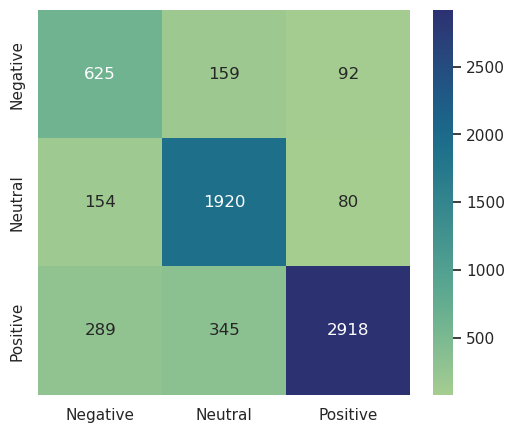

In [19]:
classes = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize = (6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), fmt = 'd', annot = True, cmap = 'crest', xticklabels = classes, yticklabels = classes)

# The End 📍 

**Conclusion:** *It seems that the majority of the people loved Threads, and they're not thinking that Threads is just a cheap copy of Twitter. I don't care much about social media but, no matter what, I'll be always the side of creativity and innovation.*

**Thank you everybody, who read this entire notebook. If you like my notebook please give an upvote. 👍**